In [3]:
import sys; 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [4]:
import tensorflow as tf

# Load MINIST Data

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print type(mnist)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>


In [6]:
print mnist.train.images.shape
print mnist.test.images.shape

(55000, 784)
(10000, 784)


In [133]:
PIXELS = mnist.train.images.shape[1]
IMG_HT = np.sqrt( PIXELS ).astype(int)
IMG_WID = PIXELS / IMG_HT
CHANNEL = 1
KLASS = 10

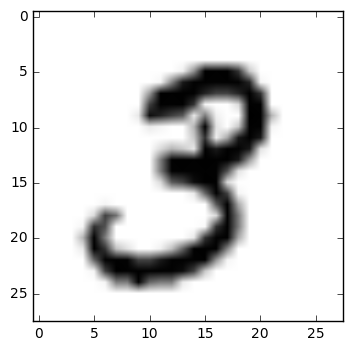

In [40]:
tmp = mnist.train.images[1] # np ndarray
tmp = tmp.reshape((IMG_SZ, IMG_SZ))
plt.imshow(tmp, cmap = cm.Greys)
plt.show()

# Session

In [9]:
sess = tf.InteractiveSession() # 

# Training

### Functions

In [14]:
# Define a weight variable. shape is a list
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [15]:
# Define a bias variable. shape is a list
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [132]:
# Define a few ops and variables
# x: placeholder, batch * h * w * ch_in
# name: e.g. 'hidden1'
# return: tensor, batch * h * w * ch_out
def conv_layer(x, h_filter, w_filter, ch_out, name):
    bat, h, w, ch_in = x.get_shape().as_list()
    with tf.name_scope( name ):
        W = weight_variable( [h_filter, w_filter, ch_in, ch_out] ) # [h_filter, h_filter, channel_in, channel_out]
        b = bias_variable( [ch_out] )
        s = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') + b
        h = tf.nn.relu( s )
        return tf.nn.max_pool( h, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME' )

In [106]:
# Define a few ops and variables
# x: placeholder, batch * dim_in
# keep_prob = tf.placeholder( tf.float32 ), if None, no dropout
# name: e.g. 'hidden1'
# return: tensor, batch * dim_out
def fc_layer(x, dim_out, activate, keep_prob, name):
    bat, dim_in = x.get_shape().as_list()
    with tf.name_scope( name ):
        W = weight_variable( [dim_in, dim_out] )
        b = bias_variable( [dim_out] )
        s = tf.matmul( x, W ) + b
        if activate == None:  # no activation
            return s
        h = tf.nn.relu( s )
        if keep_prob == None:  
            return h
        # dropout
        return tf.nn.dropout( h, keep_prob )

In [107]:
# s: logits, i.e., unscaled log prob., batch * klass
# y: labels ([0, klass-1)), 1 * batch
# return: avg. loss across samples of batch
def cross_entropy_loss( s, y ):
    return tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( s, y ) )

In [108]:
# Define an Op for train a step on batch
# loss: the output of "loss" Op 
# step_sz: placeholder
def train_step( loss, step_sz ):
    return tf.train.AdamOptimizer(step_sz).minimize(loss)

In [189]:
# s: logits, i.e., unscaled log prob., batch * klass
# y: labels, i.e. 0 or 1 over k classes, batch * klass
# return: avg. accuracy across samples of batch
def accuracy( s, y ):
    correct = tf.equal( tf.argmax(s, 1), tf.argmax(y, 1) )
    return tf.reduce_mean( tf.cast(correct, tf.float32) )

### Input Data for Graph (placeholder)

In [110]:
####
# Placeholders are usually the values that could be changed in ITERATION when runing the graph.
# The values that are only changed when constructing the graph can be normal parameters.  

In [111]:
x = tf.placeholder(tf.float32, shape=[None, PIXELS])  # batch size is foo
y = tf.placeholder(tf.float32, shape=[None, KLASS])
keep_prob = tf.placeholder(tf.float32)
step_sz = tf.placeholder(tf.float32)

### Construct Graph

In [112]:
####
# Construct graph only once. In evaluation, we change input values (placeholders) to re-use the graph

In [115]:
x_image = tf.reshape(x, [-1, IMG_HT, IMG_WID, CHANNEL])  # [batch, 28, 28, 1]
print x_image.get_shape()

(?, 28, 28, 1)


In [123]:
sz_fil = 5
# Conv 1
h1_image = conv_layer( x_image, sz_fil, sz_fil, 32, 'conv1' )  
print h1_image.get_shape()

# Conv 2
h2_image = conv_layer( h1_image, sz_fil, sz_fil, 64, 'conv2' )
print h2_image.get_shape()

# FC 1
bat, h_h2, w_h2, ch_h2 = h2_image.get_shape().as_list()
h2_flat = tf.reshape( h2_image, [-1, h_h2 * w_h2 * ch_h2] )
print h2_flat.get_shape()
h3_flat = fc_layer( h2_flat, 1024, activate='ReLu', keep_prob=keep_prob, name='fc1')
print h3_flat.get_shape()

# FC 2 (output logits)
s = fc_layer( h3_flat, KLASS, activate=None, keep_prob=None, name='out')
print s.get_shape()

(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 3136)
(?, 1024)
(?, 10)


#### Define Optimization Op

In [124]:
loss = cross_entropy_loss( s, y )
update = train_step( loss, step_sz ) # define an Op
accuracy = accuracy( s, y )

### Running Graph by Batch

In [126]:
sess.run(tf.initialize_all_variables())

In [127]:
for i in range(500):
    batch = mnist.train.next_batch(50)
    feed_dict = { x:batch[0], y: batch[1], keep_prob: 1.0, step_sz: 1e-4 }
    if i % 100 == 0:
        train_accuracy = accuracy.eval( feed_dict=feed_dict  )
        print( "step %d, training accuracy %g"%(i, train_accuracy) )
    update.run( feed_dict=feed_dict ) # compute gradient and update Variables

step 0, training accuracy 0.06
step 100, training accuracy 0.84
step 200, training accuracy 0.88
step 300, training accuracy 0.86
step 400, training accuracy 0.94


# Testing

### Overall Accuracy

In [130]:
feed_dict = { x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0 }
print( "test accuracy %g" % accuracy.eval( feed_dict=feed_dict ) )

test accuracy 0.9504


### Spot Check Sample Images

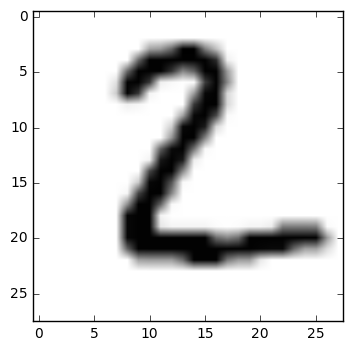

In [195]:
arr = mnist.test.images[1, :] # np ndarray
img = arr.reshape((IMG_SZ, IMG_SZ))
plt.imshow(img, cmap = cm.Greys)
plt.show()

In [162]:
arrs = mnist.test.images[0:3, :] 
labels = mnist.test.labels[0:3, :] 
print label

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [199]:
print s.eval( feed_dict={x: arrs, keep_prob: 1.0} ) # logits predicted by CNN
ss = tf.argmax(s, 1)
print ss.eval( feed_dict={x: arrs, keep_prob: 1.0} )

[[  0.43100956  -4.32141209   2.0139246    2.42280674  -4.29311848
   -1.0875144   -7.19245958  15.7839489   -3.87987351   1.71959388]
 [  3.39770579   3.37829876  12.21088028   1.05556774  -4.07108879
    0.90789735   1.18933296  -7.29820442   2.445261    -4.0108881 ]
 [ -0.32701871   5.05895996   0.71152264  -2.57343554   1.25383544
   -3.64888573  -0.07787615   0.52905464   0.21747532  -1.3826896 ]]
[7 2 1]


In [201]:
yy = tf.argmax(y, 1)
print yy.eval( feed_dict={y:labels} )

[7 2 1]


In [202]:
eq = tf.equal(ss, yy)
eq.eval( feed_dict=feed_dict )

array([ True,  True,  True], dtype=bool)